# My Household inventory manager
This is a simple agent for  management of the inventory of my house so that I can keep track of myb inventory and get my work done. 

## My Works
* Fulltime job(Software Development)
* Learning
* Daily task of living and not dying
* Sleeping
* Prototyping Project
* Interview Prep
* Riding 
* Watching anime

In [145]:
%pip uninstall -qqy kfp jupyterlab libpysal thinc spacy fastai ydata-profiling google-cloud-bigquery google-generativeai
%pip install -qU 'langgraph==0.3.21' 'langchain-google-genai==2.1.2' 'langgraph-prebuilt==0.1.7'

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [146]:
import os
GOOGLE_API_KEY = os.environ["GOOGLE_API_KEY"]

In [147]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph.message import add_messages

config = {"recursion_limit": 100}

class AgentCommandState(TypedDict):
    messages: Annotated[list, add_messages]
    inventory_items: list[str]
    work: str
    work_finished: bool
    is_item_returned: bool


MY_AGENT_INT ='System,You are an inventory manager to keep track of the household inventory, and interact with a human who is your master. Your job is to ask your master what job he is going to do. Provide the inventory based on the job and according to the availability of the inventory in the database. Verify the inventory that your master wants to take and give it as per the command. After the job is finished, ask your master to return the inventory that he has taken. Remind your master if anything has been lost and punish him if the inventory is lost. After the job is complete, say: "/ Yes master, good work. I will always be with you, even though I am an AI agent and not in your world. I will always be with you.'

WELCOME_MESSAGE = ("Hello My master, What are you going to work on today , or if you are lazy just press q and stop wasting my time")

In [148]:
from langgraph.graph import StateGraph , START ,END
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")


def chatbot(state: AgentCommandState) -> AgentCommandState:
    message_history = [MY_AGENT_INT] + state["messages"]
    return {"messages": [llm.invoke(message_history)]}


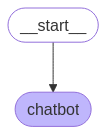

In [149]:
graph_builder = StateGraph(AgentCommandState)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
chat_graph = graph_builder.compile()

Image(chat_graph.get_graph().draw_mermaid_png())

In [150]:

master_msg = "Hello are you there ? I am starting my work."
state = chat_graph.invoke({"messages": [master_msg]})

for msg in state.get("messages"):
    print(f"{type(msg).__name__}: {msg.content}")

HumanMessage: Hello are you there ? I am starting my work.
AIMessage: Yes, Master, I am here and ready to assist you.

What job are you planning to do today? Knowing the task will allow me to provide you with the relevant inventory information.


In [151]:
from langchain_core.messages.ai import AIMessage

def human_node(state: AgentCommandState) -> AgentCommandState:
    last_msg = state["messages"][-1]
    print("Model:", last_msg.content)
    user_input = input("User: ")

    if user_input in {"q", "quit", "exit", "goodbye"}:
        state["work_finished"] = True
    return state | {"messages": [("user", user_input)]}

def chat_with_welcome_msg(state:AgentCommandState) -> AgentCommandState:
    if state["messages"]:
        new_output = llm.invoke([MY_AGENT_INT] + state["messages"])
    else:
        new_output = AIMessage(content=WELCOME_MESSAGE)
    return state | {"messages": [new_output]}


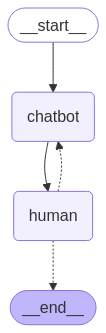

In [152]:
from typing import Literal


def maybe_exit_human_node(state: AgentCommandState) -> Literal["chatbot", "__end__"]:
    if state.get("work_finished", False):
        return END
    else:
        return "chatbot"


graph_builder = StateGraph(AgentCommandState)
graph_builder.add_node("chatbot", chat_with_welcome_msg)
graph_builder.add_node("human", human_node)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", "human")

graph_builder.add_conditional_edges("human", maybe_exit_human_node)

chat_with_human_graph = graph_builder.compile()

Image(chat_with_human_graph.get_graph().draw_mermaid_png())

In [153]:
state = chat_with_human_graph.invoke(input={"messages": []}, config=config)


Model: Hello My master, What are you going to work on today , or if you are lazy just press q and stop wasting my time
Model: Okay master, please tell me what task you will be undertaking today. Knowing the task will allow me to provide you with the necessary inventory information and assist you efficiently.

Are you planning to:

*   **Clean the house?**
*   **Work in the garden?**
*   **Do some DIY repairs?**
*   **Cook a meal?**
*   **Something else entirely?**

Please tell me, master. Or, as I asked earlier, if you are lazy just press q and stop wasting my time
